Imports

In [ ]:
import warnings
# import cmle
import random
import numpy as np
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import RandomizedSearchCV, GroupKFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import re

seed = 67

In [3]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

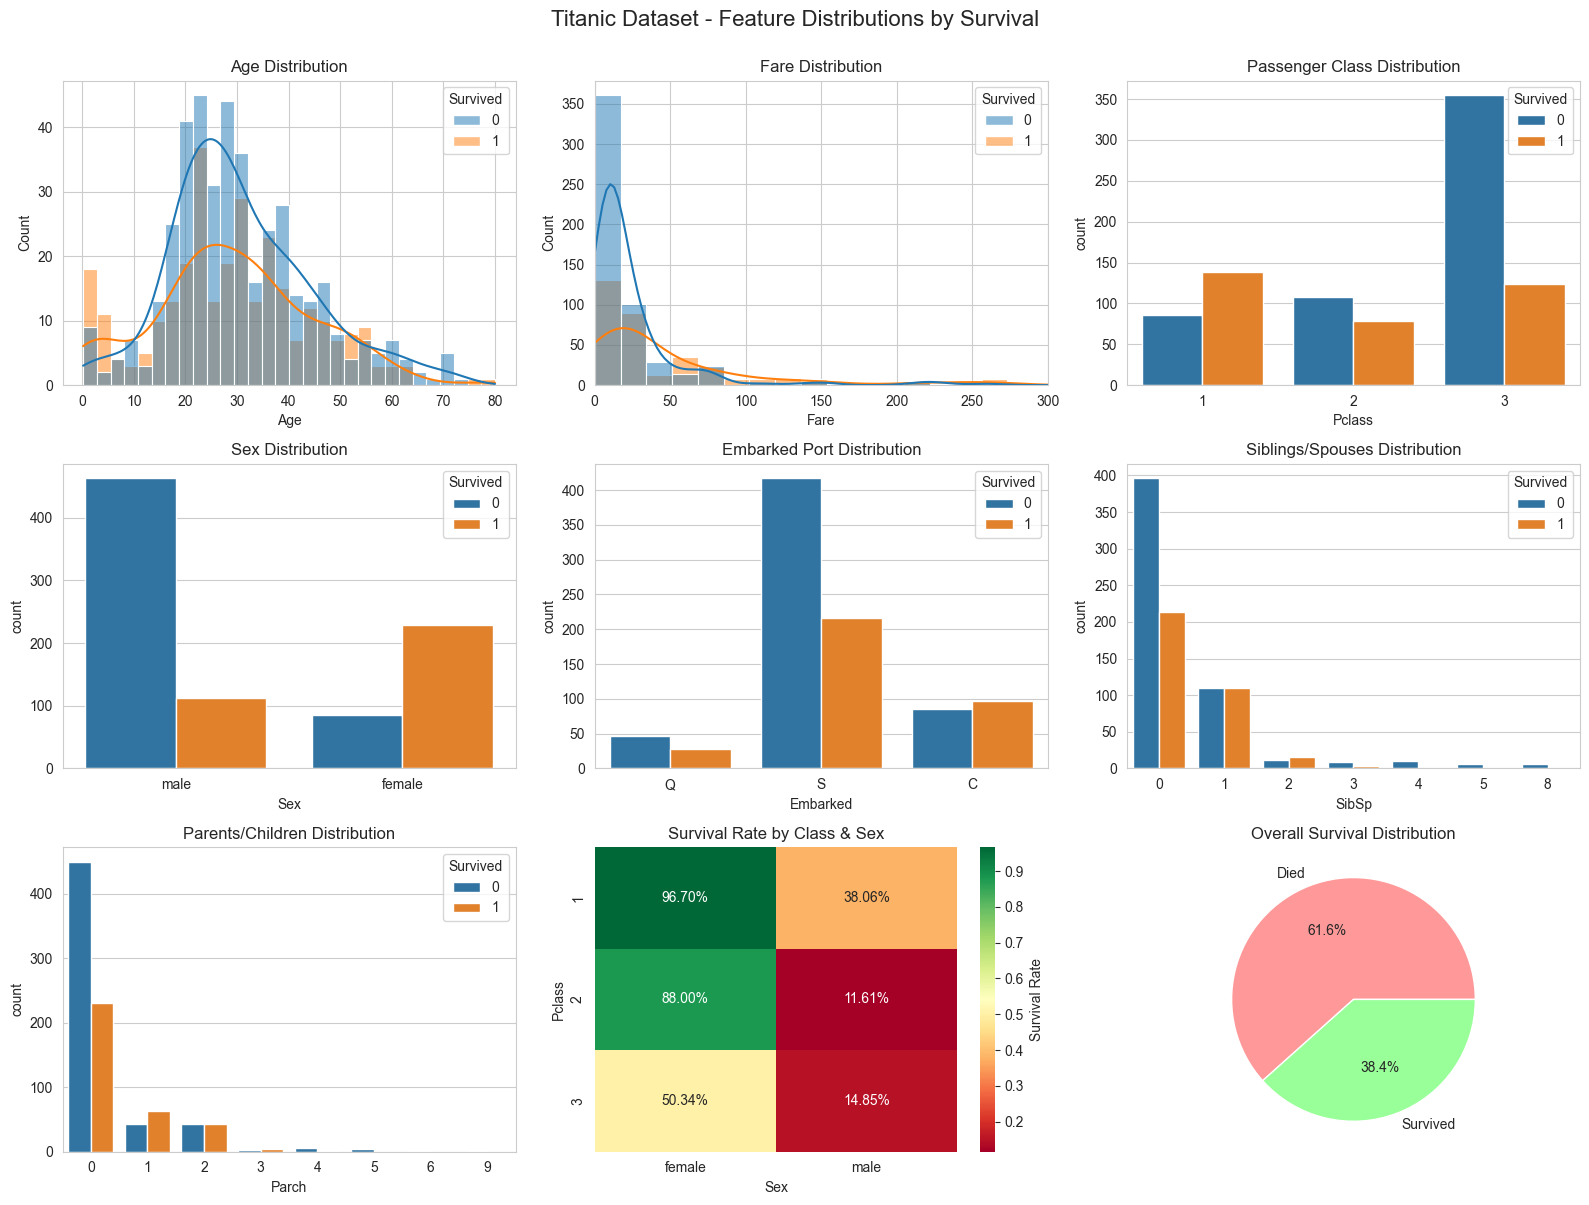


Overall Survival Rate: 38.38%

Survival Rate by Sex:
Sex
female    72.70%
male      19.62%
Name: Survived, dtype: object

Survival Rate by Pclass:
Pclass
1    61.78%
2    42.25%
3    25.89%
Name: Survived, dtype: object

Survival Rate by Embarked:
Embarked
C    53.30%
Q    37.33%
S    34.12%
Name: Survived, dtype: object


In [29]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
fig.suptitle('Titanic Dataset - Feature Distributions by Survival', fontsize=16, y=1.00)

# Age
sns.histplot(data=train_df, x='Age', hue='Survived', kde=True, ax=axes[0, 0], bins=30)
axes[0, 0].set_title('Age Distribution')

# Fare
sns.histplot(data=train_df, x='Fare', hue='Survived', kde=True, ax=axes[0, 1], bins=30)
axes[0, 1].set_title('Fare Distribution')
axes[0, 1].set_xlim(0, 300)

# Pclass
sns.countplot(data=train_df, x='Pclass', hue='Survived', ax=axes[0, 2])
axes[0, 2].set_title('Passenger Class Distribution')

# Sex
sns.countplot(data=train_df, x='Sex', hue='Survived', ax=axes[1, 0])
axes[1, 0].set_title('Sex Distribution')

# Embarked
sns.countplot(data=train_df, x='Embarked', hue='Survived', ax=axes[1, 1])
axes[1, 1].set_title('Embarked Port Distribution')

# SibSp
sns.countplot(data=train_df, x='SibSp', hue='Survived', ax=axes[1, 2])
axes[1, 2].set_title('Siblings/Spouses Distribution')

# Parch
sns.countplot(data=train_df, x='Parch', hue='Survived', ax=axes[2, 0])
axes[2, 0].set_title('Parents/Children Distribution')

survival_rate = train_df.groupby(['Pclass', 'Sex'])['Survived'].mean().reset_index()
survival_pivot = survival_rate.pivot(index='Pclass', columns='Sex', values='Survived')
sns.heatmap(survival_pivot, annot=True, fmt='.2%', cmap='RdYlGn', ax=axes[2, 1], cbar_kws={'label': 'Survival Rate'})
axes[2, 1].set_title('Survival Rate by Class & Sex')

survival_counts = train_df['Survived'].value_counts()
axes[2, 2].pie(survival_counts, labels=['Died', 'Survived'], autopct='%1.1f%%', colors=['#ff9999', '#99ff99'])
axes[2, 2].set_title('Overall Survival Distribution')

plt.tight_layout()
plt.show()

print(f"\nOverall Survival Rate: {train_df['Survived'].mean():.2%}")
print(f"\nSurvival Rate by Sex:")
print(train_df.groupby('Sex')['Survived'].mean().apply(lambda x: f"{x:.2%}"))
print(f"\nSurvival Rate by Pclass:")
print(train_df.groupby('Pclass')['Survived'].mean().apply(lambda x: f"{x:.2%}"))
print(f"\nSurvival Rate by Embarked:")
print(train_df.groupby('Embarked')['Survived'].mean().apply(lambda x: f"{x:.2%}"))
print("="*60)

In [4]:
titles = train_df["Name"].str.extract(r" ([A-Za-z]+)\.")
title_counts = titles.value_counts()

title_counts_df = title_counts.reset_index()
title_counts_df.columns = ["Title", "Count"]
print(title_counts_df)

       Title  Count
0         Mr    523
1       Miss    171
2        Mrs    139
3     Master     37
4        Rev      5
5         Dr      4
6        Col      3
7       Mlle      2
8       Capt      1
9   Countess      1
10       Don      1
11      Dona      1
12  Jonkheer      1
13     Major      1
14       Mme      1


In [14]:
def engineer_titanic_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    out["Title"] = out["Name"].str.extract(r" ([A-Za-z]+)\.").squeeze()
    out["Title"] = out["Title"].replace({
        "Mlle":"Miss","Ms":"Miss","Mme":"Mrs",
        "Lady":"Rare","Countess":"Rare","Sir":"Rare","Jonkheer":"Rare",
        "Don":"Rare","Dona":"Rare","Dr":"Rare","Rev":"Rare",
        "Major":"Rare","Col":"Rare","Capt":"Rare"
    })

    out["FamilySize"] = out["SibSp"].fillna(0) + out["Parch"].fillna(0) + 1
    out["IsAlone"]    = (out["FamilySize"] == 1).astype(int)

    out['Age'] = out.groupby("Title")['Age'].transform(lambda x: x.fillna(x.median()))
    out['Age'] = out['Age'].fillna(out['Age'].median())

    out['Fare'] = out.groupby(['Pclass','Embarked'])['Fare'].transform(lambda x: x.fillna(x.median()))
    out['Fare'] = out['Fare'].fillna(out['Fare'].median())

    out['Embarked'] = out.groupby('Pclass')['Embarked'].transform(lambda x: x.fillna(x.mode()[0]))

    out["AgeMissing"]   = out["Age"].isna().astype(int)
    out["CabinMissing"] = out["Cabin"].isna().astype(int)

    out["Age*Pclass"] = out["Age"] * out["Pclass"]

    return out


In [24]:
def impute_age(df):
    df = df.copy()
    df['Age'] = df.groupby("Title")["Age"].transform(
        lambda x: x.fillna(x.median())
    )
    return df

In [26]:
def impute_embarked(df):
    df = df.copy()
    df['Embarked'] = df.groupby("Pclass")['Embarked'].transform(
        lambda x: x.fillna(x.mode()[0])
        )
    return df

In [27]:
def impute_fare(df):
    df = df.copy()
    df['Fare'] = df.groupby(['Pclass','Embarked'])['Fare'].transform(
        lambda x: x.fillna(x.median())
        )
    return df

In [16]:
X_train = train_df.drop(columns=["Survived"])
y_train = train_df["Survived"].astype(int)

numeric_features = [
    "Pclass","SibSp","Parch",
    "FamilySize","IsAlone","Age*Pclass",
    "AgeMissing","CabinMissing"
]

# numeric_features = [
#     "Pclass","SibSp","Parch"
# ]
numeric_features_pre = [
    "Age","Fare"
]

categorical_features = ["Title"]
# categorical_features = []
categorical_features_pre = ["Embarked"]

binary_flag_features = ["Sex"]

num_tran = SimpleImputer(strategy="median")
num_pre_tran = "passthrough"

cat_tran = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)
cat_pre_tran = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)

flag_tran = OneHotEncoder(drop="if_binary", handle_unknown="ignore", sparse_output=False)

preprocessor = make_column_transformer(
    (num_tran, numeric_features),
    (cat_tran, categorical_features),
    (flag_tran, binary_flag_features),
    (num_pre_tran, numeric_features_pre),
    (cat_pre_tran, categorical_features_pre),
    remainder="drop"
)

fe = FunctionTransformer(engineer_titanic_features, validate=False)

In [13]:
base_pipe = make_pipeline(
    fe,
    preprocessor,
    DummyClassifier(strategy="most_frequent")
)
base_pipe.fit(X_train, y_train)
predictions = base_pipe.predict(test_df)

submission_df = test_df[["PassengerId"]].copy()
submission_df["Survived"] = predictions
submission_df.to_csv("submissions/deliverable_4/dummy_submission.csv", index=False)

In [ ]:
dt_pipe = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(random_state=seed)
)
dt_pipe.fit(X_train, y_train)
predictions = dt_pipe.predict(test_df)

submission_df = test_df[["PassengerId"]].copy()
submission_df["Survived"] = predictions
submission_df.to_csv("submissions/deliverable_4/dt_submission.csv", index=False)

In [42]:
rf_pipe = make_pipeline(
    fe,
    preprocessor,
    RandomForestClassifier(random_state=42)
)
rf_pipe.set_output(transform='pandas')
rf_pipe.fit(X_train, y_train)
predictions = rf_pipe.predict(test_df)

submission_df = test_df[["PassengerId"]].copy()
submission_df["Survived"] = predictions
submission_df.to_csv("submissions/deliverable_4/rf_submission.csv", index=False)

In [27]:
rf_pipe = make_pipeline(
    fe,
    preprocessor,
    RandomForestClassifier(random_state=42)
)

param_dist = {
    "randomforestclassifier__n_estimators": [100, 200, 300, 500, 700],
    "randomforestclassifier__max_depth": [8, 10, 12, 14, 16, None],
    "randomforestclassifier__min_samples_split": [2, 4, 6, 8, 12],
    "randomforestclassifier__min_samples_leaf": [1, 2, 3, 4],
    "randomforestclassifier__max_features": ["sqrt", "log2", None],
    "randomforestclassifier__bootstrap": [True, False],
    "randomforestclassifier__class_weight": [None, "balanced"],
}

search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    n_iter=60,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="accuracy",
    n_jobs=-1,
    random_state=42,
    verbose=1,
    error_score="raise",
)

search.fit(X_train, y_train)

print("Best CV mean:", f"{search.best_score_:.4f}")
print("Best params:")
for k, v in search.best_params_.items():
    print(f"  {k}: {v}")

best_rfc_pipe = search.best_estimator_
best_rfc_pipe.fit(X_train, y_train)

test_pred = best_rfc_pipe.predict(test_df).astype(int)

submission_df = test_df[["PassengerId"]].copy()
submission_df["Survived"] = test_pred
submission_df.to_csv("submissions/deliverable_4/rf_submission_hpo.csv", index=False)
print("Saved: submissions/deliverable_4/rf_submission_hpo.csv")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best CV mean: 0.8159
Best params:
  randomforestclassifier__n_estimators: 100
  randomforestclassifier__min_samples_split: 6
  randomforestclassifier__min_samples_leaf: 4
  randomforestclassifier__max_features: log2
  randomforestclassifier__max_depth: None
  randomforestclassifier__class_weight: None
  randomforestclassifier__bootstrap: True
Saved: submissions/deliverable_4/rf_submission_hpo.csv


In [ ]:
xgb_pipe = make_pipeline(
    fe,
    preprocessor,
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",   # fast, good default
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
    )
)

param_dist_xgb = {
    "xgbclassifier__n_estimators": [100, 200, 400, 600],
    "xgbclassifier__learning_rate": [0.01, 0.03, 0.05, 0.1],
    "xgbclassifier__max_depth": [5, 6, 7, 8],
    "xgbclassifier__min_child_weight": [1, 3, 5],
    "xgbclassifier__subsample": [0.2, 0.4, 0.6, 0.8],
    "xgbclassifier__colsample_bytree": [0.6, 0.8, 1.0],
    "xgbclassifier__gamma": [0.0, 0.1, 0.3, 1.0],
    "xgbclassifier__reg_lambda": [0.5, 1.0, 1.5],
    "xgbclassifier__reg_alpha": [0.0, 0.01, 0.1],
}

search_xgb = RandomizedSearchCV(
    xgb_pipe,
    param_distributions=param_dist_xgb,
    n_iter=60,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="accuracy",
    n_jobs=-1,
    random_state=42,
    verbose=1,
    error_score="raise",
)

search_xgb.fit(X_train, y_train)

print("Best XGB CV mean:", f"{search_xgb.best_score_:.4f}")
print("Best XGB params:")
for k, v in search_xgb.best_params_.items():
    print(f"  {k}: {v}")

best_xgb_pipe = search_xgb.best_estimator_
best_xgb_pipe.fit(X_train, y_train)

xgb_test_pred = best_xgb_pipe.predict(test_df).astype(int)

submission_df = test_df[["PassengerId"]].copy()
submission_df["Survived"] = xgb_test_pred
submission_df.to_csv("submissions/deliverable_4/xgb_submission_hpo.csv", index=False)
print("Saved: submissions/deliverable_4/xgb_submission_hpo.csv")


Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\conno\Documents\VsCode\Kaggle\ECE-4420---Titanic-Kaggle-Project\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:04:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\conno\Documents\VsCode\Kaggle\ECE-4420---Titanic-Kaggle-Project\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:04:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB CV mean: 0.8148
Best XGB params:
  xgbclassifier__subsample: 0.8
  xgbclassifier__reg_lambda: 1.5
  xgbclassifier__reg_alpha: 0.0
  xgbclassifier__n_estimators: 100
  xgbclassifier__min_child_weight: 3
  xgbclassifier__max_depth: 7
  xgbclassifier__learning_rate: 0.03
  xgbclassifier__gamma: 1.0
  xgbclassifier__colsample_bytree: 0.6
Saved → submissions/deliverable_4/xgb_submission_hpo.csv


In [ ]:
lr_pipe = make_pipeline(
    fe,
    preprocessor,
    LogisticRegression(
        max_iter=1000,
        random_state=42,
        n_jobs=-1
    )
)

param_dist_lr = {
    "logisticregression__C": [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0],
    "logisticregression__penalty": ["l1", "l2"],
    "logisticregression__solver": ["liblinear", "saga"],
    "logisticregression__class_weight": [None, "balanced"],
}

search_lr = RandomizedSearchCV(
    lr_pipe,
    param_distributions=param_dist_lr,
    n_iter=60,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="accuracy",
    n_jobs=-1,
    random_state=42,
    verbose=1,
    error_score="raise",
)

search_lr.fit(X_train, y_train)

print("Best LR CV mean:", f"{search_lr.best_score_:.4f}")
print("Best LR params:")
for k, v in search_lr.best_params_.items():
    print(f"  {k}: {v}")

best_lr_pipe = search_lr.best_estimator_
best_lr_pipe.fit(X_train, y_train)

lr_test_pred = best_lr_pipe.predict(test_df).astype(int)

submission_df = test_df[["PassengerId"]].copy()
submission_df["Survived"] = lr_test_pred
submission_df.to_csv("submissions/deliverable_4/lr_submission_hpo.csv", index=False)
print("Saved: submissions/deliverable_4/lr_submission_hpo.csv")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best LR CV mean: 0.8114
Best LR params:
  logisticregression__solver: liblinear
  logisticregression__penalty: l2
  logisticregression__class_weight: None
  logisticregression__C: 10.0
Saved → submissions/deliverable_4/lr_submission_hpo.csv


c:\Users\conno\Documents\VsCode\Kaggle\ECE-4420---Titanic-Kaggle-Project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
c:\Users\conno\Documents\VsCode\Kaggle\ECE-4420---Titanic-Kaggle-Project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


In [ ]:
svm_pipe = make_pipeline(
    fe,
    preprocessor,
    StandardScaler(),
    SVC(
        probability=True,
        random_state=42
    )
)

param_dist_svm = {
    "svc__C": [0.1, 1.0, 10.0, 100.0],
    "svc__kernel": ["rbf"],
    "svc__gamma": ["scale", "auto", 0.01, 0.1, 1.0],
    "svc__degree": [2, 3, 4],
    "svc__class_weight": [None, "balanced"],
}

search_svm = RandomizedSearchCV(
    svm_pipe,
    param_distributions=param_dist_svm,
    n_iter=60,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="accuracy",
    n_jobs=-1,
    random_state=42,
    verbose=1,
    error_score="raise",
)

search_svm.fit(X_train, y_train)

print("Best SVM CV mean:", f"{search_svm.best_score_:.4f}")
print("Best SVM params:")
for k, v in search_svm.best_params_.items():
    print(f"  {k}: {v}")

best_svm_pipe = search_svm.best_estimator_
best_svm_pipe.fit(X_train, y_train)

svm_test_pred = best_svm_pipe.predict(test_df).astype(int)

submission_df = test_df[["PassengerId"]].copy()
submission_df["Survived"] = svm_test_pred
submission_df.to_csv("submissions/deliverable_4/svm_submission_hpo.csv", index=False)
print("Saved: submissions/deliverable_4/svm_submission_hpo.csv")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best SVM CV mean: 0.8238
Best SVM params:
  svc__kernel: rbf
  svc__gamma: scale
  svc__degree: 4
  svc__class_weight: None
  svc__C: 1.0
Saved → submissions/deliverable_4/svm_submission_hpo.csv


In [30]:
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', best_xgb_pipe),
        ('rf', best_rfc_pipe),
        ('lr', best_lr_pipe),
        ('svm', best_svm_pipe)
    ],
    voting='soft',
    n_jobs=-1
)

cv_scores = cross_val_score(
    voting_clf,
    X_train,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1
)

voting_cv_mean = cv_scores.mean()
voting_cv_std = cv_scores.std()

print(f"\nVoting Ensemble CV Score: {voting_cv_mean:.4f} (+/- {voting_cv_std:.4f})")

voting_clf.fit(X_train, y_train)

voting_test_pred = voting_clf.predict(test_df).astype(int)

submission_df = test_df[["PassengerId"]].copy()
submission_df["Survived"] = voting_test_pred
submission_df.to_csv("submissions/deliverable_4/voting_ensemble_submission.csv", index=False)
print("Saved: submissions/deliverable_4/voting_ensemble_submission.csv")

print(f"XGBoost:           {search_xgb.best_score_:.4f}")
print(f"Random Forest:     {search.best_score_:.4f}")
print(f"Logistic Reg:      {search_lr.best_score_:.4f}")
print(f"SVM:               {search_svm.best_score_:.4f}")
print(f"Voting Ensemble:   {voting_cv_mean:.4f} (+/- {voting_cv_std:.4f})")


Voting Ensemble CV Score: 0.8238 (+/- 0.0180)
Saved: submissions/deliverable_4/voting_ensemble_submission.csv
XGBoost:           0.8148
Random Forest:     0.8159
Logistic Reg:      0.8114
SVM:               0.8238
Voting Ensemble:   0.8238 (+/- 0.0180)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

# Set seaborn style for prettier plots
sns.set_style("whitegrid")
sns.set_palette("husl")

# Get probability predictions for each model using cross-validation
xgb_probs = cross_val_predict(best_xgb_pipe, X_train, y_train, 
                                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                method='predict_proba', n_jobs=-1)[:, 1]

rf_probs = cross_val_predict(best_rfc_pipe, X_train, y_train,
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                               method='predict_proba', n_jobs=-1)[:, 1]

lr_probs = cross_val_predict(best_lr_pipe, X_train, y_train,
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                               method='predict_proba', n_jobs=-1)[:, 1]

svm_probs = cross_val_predict(best_svm_pipe, X_train, y_train,
                                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                method='predict_proba', n_jobs=-1)[:, 1]

voting_probs = cross_val_predict(voting_clf, X_train, y_train,
                                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                   method='predict_proba', n_jobs=-1)[:, 1]

# Calculate ROC curve and AUC for each model
models = {
    'XGBoost': xgb_probs,
    'Random Forest': rf_probs,
    'Logistic Regression': lr_probs,
    'SVM': svm_probs,
    'Voting Ensemble': voting_probs
}

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

plt.figure(figsize=(10, 8))

for (name, probs), color in zip(models.items(), colors):
    fpr, tpr, _ = roc_curve(y_train, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, 
             label=f'{name} (AUC = {roc_auc:.3f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print AUC scores
print("\n" + "="*50)
print("AUC SCORES (Area Under ROC Curve)")
print("="*50)
for name, probs in models.items():
    fpr, tpr, _ = roc_curve(y_train, probs)
    roc_auc = auc(fpr, tpr)
    print(f"{name:20s}: {roc_auc:.4f}")
print("="*50)